- This notebook is to perform modeling for the latent space of single surfactants, binary system, and amphiphiles cases

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '2'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import plotly.graph_objs as go
import plotly.io as pio

### Surfactants data

In [4]:
file_path = '/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/data/SurfPro_v1/data/surfpro_literature.csv'
df_data = pd.read_csv(file_path)

df_ = df_data.iloc[:, [0, 1, 3]]
df_cleaned = df_.dropna()
df_data_clean = df_cleaned.reset_index(drop=True)
df_data_clean.head()

,SMILES,Surfactant_Type,pCMC
0,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCC)C[N+](C)(C)...,gemini cationic,3.102373
1,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCC)C[N+](C)(...,gemini cationic,3.619789
2,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCCCC)C[N+](C...,gemini cationic,4.508638
3,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCC.[Br-],cationic,2.384050
4,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCCCC.[Br-],cationic,2.899629


In [5]:
# single surfactants dataset
surfactant_latent = np.load("surfactant_emb_2d_VICGAE.npy")
surfactant_latent.shape

(1395, 32)

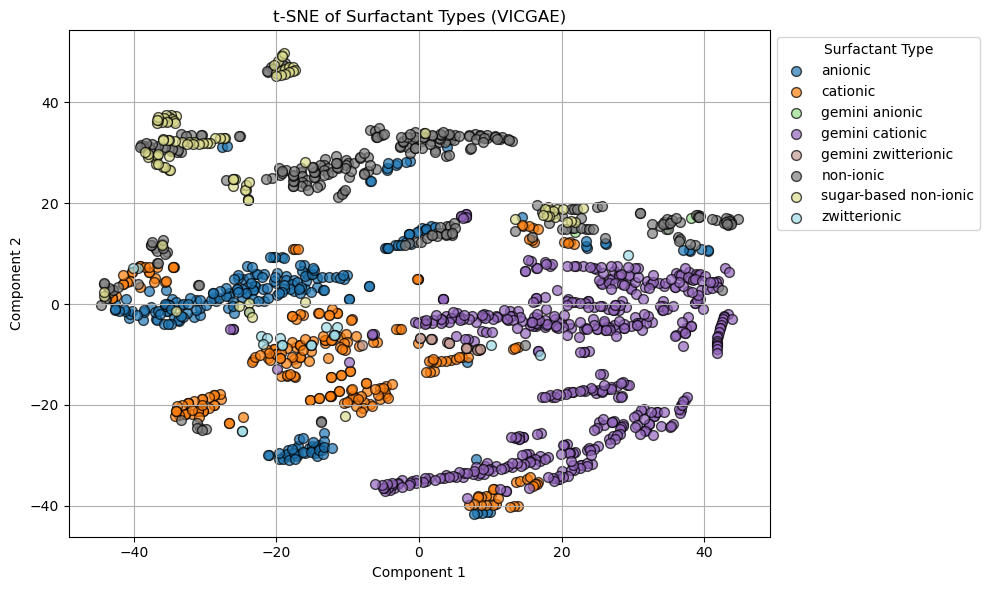

In [7]:
# Prepare input and labels
X = surfactant_latent
y = df_data_clean['Surfactant_Type']

# Create color dictionary
surfactant_types = np.unique(y)
colors = plt.cm.tab20(np.linspace(0, 1, len(surfactant_types)))
color_dict = dict(zip(surfactant_types, colors))

# Choose dimension reduction method
reducer = TSNE(n_components=2, random_state=42)  # or PCA(n_components=2)
X_reduced = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(10,6))
for surfactant in surfactant_types:
    idx = (y == surfactant)
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], 
                color=color_dict[surfactant], 
                label=surfactant, 
                alpha=0.7, edgecolor='k', s=50)

plt.legend(title='Surfactant Type', loc='best', frameon=True, bbox_to_anchor=(1, 1))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE of Surfactant Types (VICGAE)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import plotly.graph_objs as go
import plotly.io as pio

# Choose 3D dimension reduction
reducer = TSNE(n_components=3, random_state=42)  # or PCA(n_components=3)
X_reduced = reducer.fit_transform(X)

# Create Plotly traces
traces = []
for surfactant in surfactant_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_reduced[idx, 0],
        y=X_reduced[idx, 1],
        z=X_reduced[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=f'rgb({color_dict[surfactant][0]*255},{color_dict[surfactant][1]*255},{color_dict[surfactant][2]*255})',
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=surfactant
    )
    traces.append(trace)

# Layout
layout = go.Layout(
    title='t-SNE of Surfactant Types (3D)',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    legend=dict(title='Surfactant Type'),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)


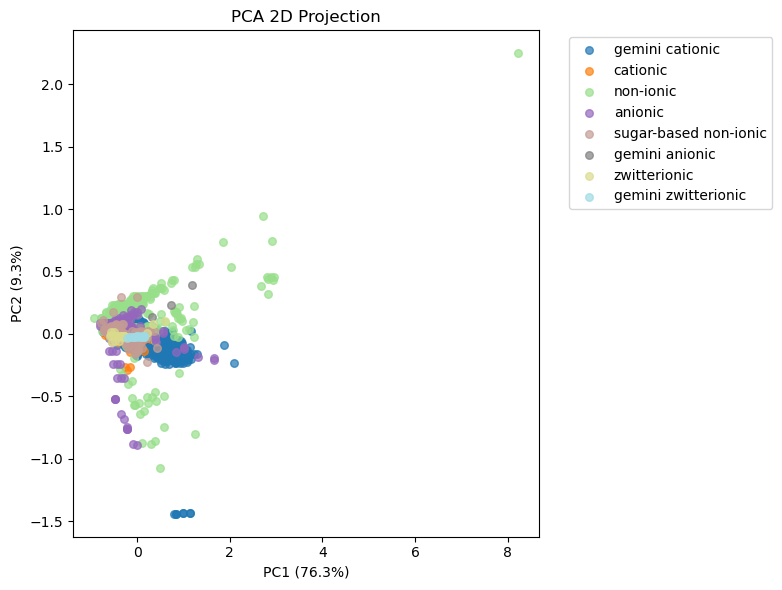

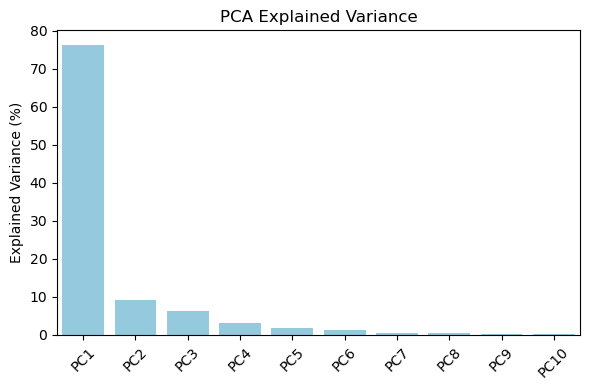

In [11]:
pca = PCA(n_components=10)  # more components to see variance
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_

# 3. Color mapping
surfactant_types = df_data_clean['Surfactant_Type'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(surfactant_types)))
color_dict = dict(zip(surfactant_types, colors))

# 4. 2D Scatter Plot
plt.figure(figsize=(8,6))
for surfactant in surfactant_types:
    idx = (y == surfactant)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                color=color_dict[surfactant], 
                label=surfactant, alpha=0.7, s=30)

plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
plt.title('PCA 2D Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. 3D Interactive Scatter Plot
traces = []
for surfactant in surfactant_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_pca[idx, 0],
        y=X_pca[idx, 1],
        z=X_pca[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=f'rgb({color_dict[surfactant][0]*255},{color_dict[surfactant][1]*255},{color_dict[surfactant][2]*255})',
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=surfactant
    )
    traces.append(trace)

layout = go.Layout(
    title='PCA 3D Projection',
    scene=dict(
        xaxis_title=f'PC1 ({explained_variance[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({explained_variance[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({explained_variance[2]*100:.1f}%)'
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    legend=dict(title='Surfactant Type')
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)

# 6. Explained Variance Plot
plt.figure(figsize=(6,4))
sns.barplot(x=[f'PC{i+1}' for i in range(10)], y=explained_variance*100, color='skyblue')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
encodings_df = pd.DataFrame(surfactant_latent) 
df_total = pd.concat([encodings_df, df_data_clean[['Surfactant_Type', 'pCMC']]], axis=1)
df_total

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,Surfactant_Type,pCMC
0,0.126507,-0.292282,0.269726,0.197819,-0.310444,0.237475,0.039809,0.178617,0.210870,-0.314403,...,-0.250793,-0.337144,-0.238680,0.358088,0.300466,-0.239091,0.336340,-0.028181,gemini cationic,3.102373
1,0.161576,-0.316007,0.303903,0.219600,-0.327044,0.266383,0.035082,0.194145,0.247067,-0.341612,...,-0.268712,-0.352501,-0.279982,0.389918,0.314075,-0.287690,0.352540,-0.035765,gemini cationic,3.619789
2,0.204128,-0.345509,0.343565,0.259726,-0.360530,0.310840,0.039001,0.215532,0.292916,-0.369677,...,-0.297768,-0.397231,-0.307623,0.422857,0.343355,-0.322493,0.387318,-0.040816,gemini cationic,4.508638
3,0.070986,-0.156905,0.151639,0.119548,-0.164228,0.128342,0.052120,0.058778,0.127450,-0.175862,...,-0.138292,-0.161335,-0.124679,0.183632,0.167813,-0.130630,0.190421,-0.002939,cationic,2.384050
4,0.086600,-0.171577,0.167221,0.131681,-0.178890,0.142493,0.054071,0.068261,0.142623,-0.190378,...,-0.152449,-0.176851,-0.139739,0.199133,0.181108,-0.146197,0.202925,-0.006301,cationic,2.899629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,-0.104882,-0.113376,0.248447,0.265131,-0.259832,0.234607,0.078569,0.256032,0.147261,-0.338376,...,-0.361969,-0.452080,-0.210227,0.424534,0.246061,-0.096334,0.423209,0.094012,non-ionic,4.432033
1391,-0.152152,-0.105908,0.223039,0.223585,-0.222404,0.193892,0.058643,0.267132,0.101961,-0.292643,...,-0.319569,-0.414945,-0.194384,0.381822,0.205546,-0.049496,0.394896,0.102166,non-ionic,4.552997
1392,-0.176099,-0.102308,0.210220,0.202778,-0.203565,0.173587,0.049275,0.272801,0.079206,-0.269819,...,-0.297343,-0.396199,-0.186543,0.360546,0.185344,-0.025942,0.380392,0.106228,non-ionic,4.602060
1393,-0.148201,-0.119238,0.270084,0.248110,-0.267853,0.233411,0.050159,0.270555,0.147447,-0.329125,...,-0.358935,-0.460179,-0.239279,0.427993,0.248382,-0.096101,0.404829,0.093558,non-ionic,4.585027


In [7]:
df_total.to_csv('df_total_surfactants_VICGAE_20250707.csv', index=False)

RMSE score : 0.608790122677065
R2 score : 0.665607074530292


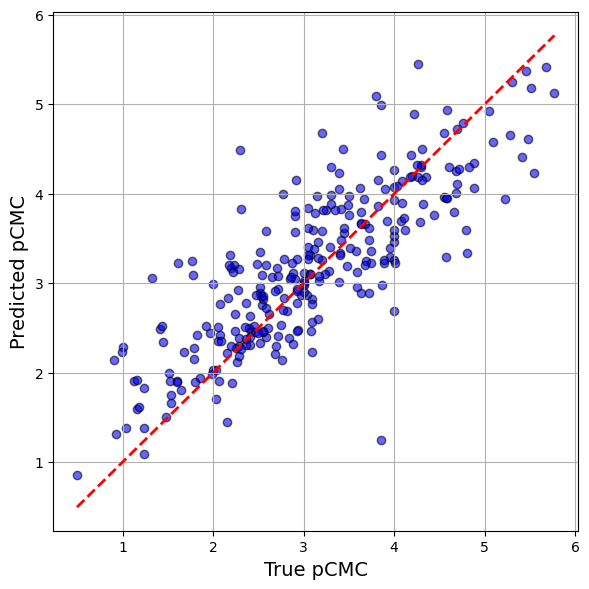

In [14]:
property_='pCMC'
train_df, test_df = train_test_split(
        df_total,
        test_size=0.2, 
        stratify=df_total['Surfactant_Type'],
        random_state=42  # for reproducibility
    )

train_x = train_df.iloc[:,0:32]
train_y = train_df[property_]

test_x = test_df.iloc[:,0:32]
test_y = test_df[property_]

# regressor = SVR(kernel="rbf", degree=3, C=5, gamma="scale", epsilon=0.01)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
model = TransformedTargetRegressor(regressor=regressor,
                                transformer=MinMaxScaler(feature_range=(-1, 1))
                                ).fit(train_x, train_y)

pred_y = model.predict(test_x)
RMSE_score = np.sqrt(mean_squared_error(test_y, pred_y))
r2 = r2_score(test_y, pred_y)

print(f"RMSE score : {RMSE_score}" )
print(f"R2 score : {r2}" )

# Scatter plot: True vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(test_y, pred_y, color='blue', alpha=0.6, edgecolor='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--', lw=2)  # y = x line
plt.xlabel(f'True {property_}', fontsize=14)
plt.ylabel(f'Predicted {property_}', fontsize=14)
# plt.title('SVR Prediction vs True Values', fontsize=16)
plt.grid(True)
plt.tight_layout()

# plot_path = os.path.join(save_dir, f'prediction_{property}_{time_str}.png')
# plt.savefig(plot_path, dpi=300)
# fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
# plt.close()

### Binary system

In [8]:
import joblib

In [9]:
# joblib.dump((x_latent, y), "binary_mixture_latent_VICGAE.joblib")
x_latent_binary, y_binary = joblib.load("binary_mixture_latent_VICGAE.joblib")

In [17]:
x_latent_binary.shape

(1326, 32)

In [10]:
df_total = pd.concat([pd.DataFrame(x_latent_binary),pd.DataFrame(y_binary, columns=['miscibility'])], axis=1)
df_total.shape

(1326, 33)

In [23]:
df_total.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,miscibility
0,-0.033440,-0.149936,0.203942,0.082680,-0.257894,0.151415,-0.028325,0.056704,0.124356,-0.233667,...,0.168699,-0.232500,-0.187731,-0.137193,0.239256,0.170732,-0.126500,0.281331,-0.060375,1
1,-0.022998,-0.108275,0.338476,0.133594,-0.336750,0.294144,-0.097542,0.128064,0.245710,-0.292554,...,0.236866,-0.335542,-0.204032,-0.214149,0.292034,0.157927,-0.211853,0.374579,-0.139083,1
2,0.005355,-0.080140,0.334111,0.090265,-0.411793,0.365886,-0.119437,0.165348,0.226056,-0.314790,...,0.211970,-0.408188,-0.182399,-0.183878,0.255771,0.188339,-0.208003,0.471196,-0.256088,1
3,-0.040176,-0.124055,0.397458,0.149334,-0.375726,0.331232,-0.125518,0.158574,0.266168,-0.324415,...,0.284588,-0.364391,-0.264148,-0.253910,0.341902,0.157011,-0.230570,0.407212,-0.135120,1
4,-0.038126,-0.124781,0.394534,0.145499,-0.372139,0.327880,-0.124344,0.158893,0.261939,-0.323043,...,0.282382,-0.359498,-0.264842,-0.251832,0.338421,0.156982,-0.229084,0.402447,-0.132215,1


In [11]:
df_total.to_csv('df_total_binary_VICGAE_20250707.csv', index=False)

In [24]:
data_ = df_total.copy()
train_df, test_df = train_test_split(
        data_,
        test_size=0.2,  
        random_state=42  # for reproducibility
    )

train_x = train_df.iloc[:,0:-1]
train_y = train_df['miscibility']

test_x = test_df.iloc[:,0:-1]
test_y = test_df['miscibility']

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier


def run_classifier_update(xtrain, ytrain, xtest, ytest, classifier_alter=False):
    if classifier_alter == False:
        # Train XGBoost classifier
        clf = XGBClassifier(n_estimators=5000, learning_rate=0.01, max_depth=10, use_label_encoder=False, eval_metric='logloss')
        clf.fit(xtrain, ytrain)

        # Predict probabilities for ROC-AUC
        # y_pred = xgb_clf.predict(xtest)
        y_pred = clf.predict_proba(xtest)[:,1]

    elif classifier_alter == True:
        clf = RandomForestClassifier(
            n_estimators=500,  # You can adjust this
            max_depth=10,      # You can tune this as well
            random_state=42,
            class_weight='balanced'  # Helps if data is imbalanced
        )
        clf.fit(xtrain, ytrain)

        # Predict probabilities for ROC-AUC
        y_pred = clf.predict_proba(xtest)[:, 1]

    # ROC-AUC score
    roc_auc = roc_auc_score(ytest, y_pred)
    fpr, tpr, threshold = roc_curve(ytest, y_pred)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    return clf, y_pred, roc_auc, fpr, tpr, threshold

In [28]:
clf, y_pred, roc_auc, fpr, tpr, threshold = run_classifier_update(train_x, train_y, test_x, test_y, classifier_alter=True)

ROC-AUC Score: 0.6580


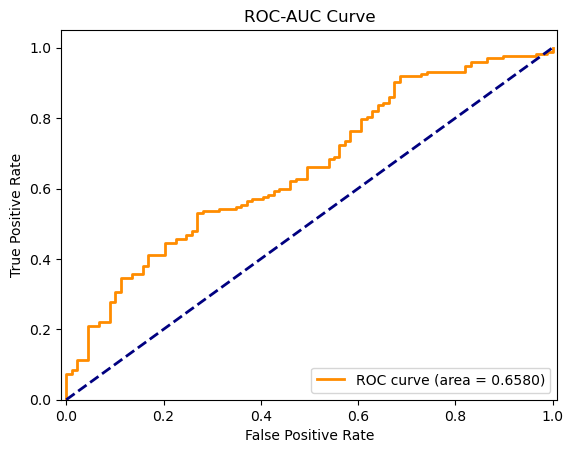

In [29]:
fig, ax = plt.subplots()
ax.set_title("ROC-AUC Curve")
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.set_title(f'ROC ({feature}_removed)')
ax.legend(loc='lower right')

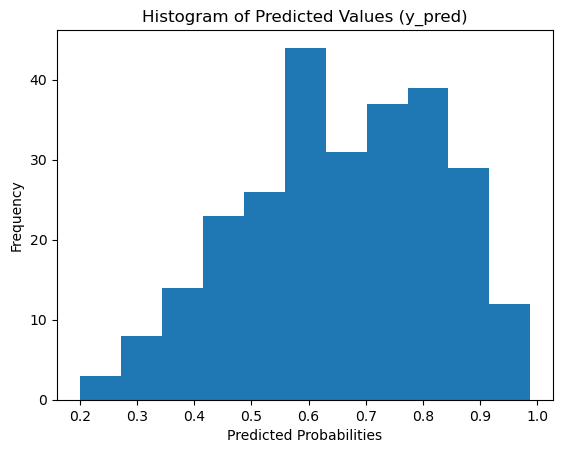

In [30]:
plt.hist(y_pred, bins='auto')  # 'auto' chooses the number of bins automatically

# Add labels and title
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values (y_pred)')

# Show the plot
plt.show()

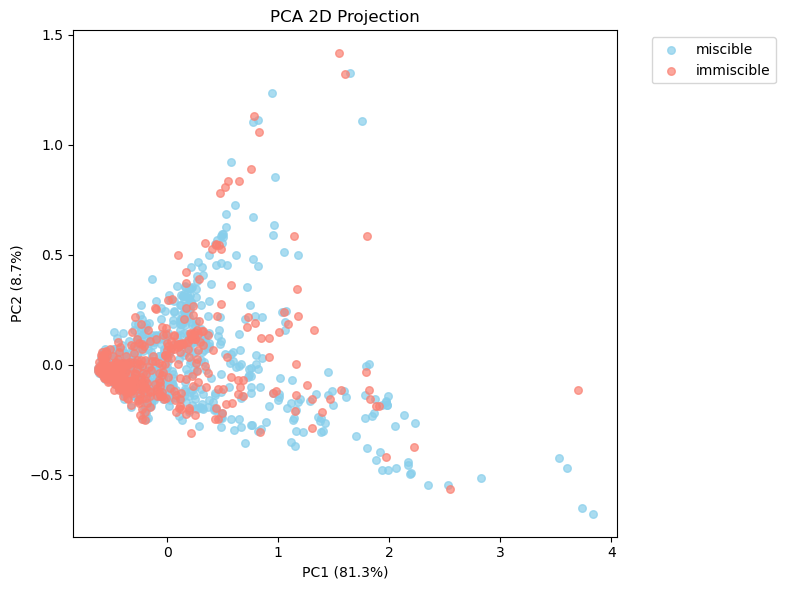

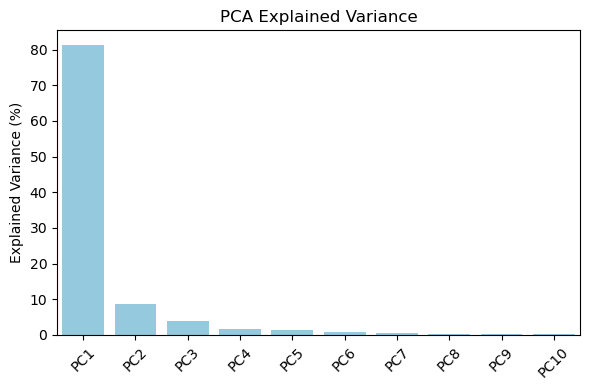

In [31]:
X = df_total.iloc[:, 0:-1].values
y = df_total['miscibility'].values

# 2. PCA
pca = PCA(n_components=10)  # Keep more components initially
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_

# 3. Color mapping for two miscibility types
miscibility_types = df_total['miscibility'].unique()
if len(miscibility_types) != 2:
    print(f"Warning: Found {len(miscibility_types)} unique miscibility types. Ensure there are exactly two for the color mapping.")

colors = ['skyblue', 'salmon']  # Define your two colors
color_dict = dict(zip(miscibility_types, colors))
legends = ['miscible', 'immiscible']
# 4. 2D Scatter Plot
plt.figure(figsize=(8, 6))
for i, surfactant in enumerate(miscibility_types):
    idx = (y == surfactant)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=color_dict[surfactant],
                label=legends[i], alpha=0.7, s=30)

plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
plt.title('PCA 2D Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. 3D Interactive Scatter Plot
traces = []
for surfactant in miscibility_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_pca[idx, 0],
        y=X_pca[idx, 1],
        z=X_pca[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color_dict[surfactant],
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=str(surfactant)
    )
    traces.append(trace)

layout = go.Layout(
    title='PCA 3D Projection',
    scene=dict(
        xaxis_title=f'PC1 ({explained_variance[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({explained_variance[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({explained_variance[2]*100:.1f}%)'
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    legend=dict(title='Miscible or not (1 for miscible, 0 for immisible')
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)

# 6. Explained Variance Plot (remains the same as it shows overall variance)
plt.figure(figsize=(6, 4))
sns.barplot(x=[f'PC{i+1}' for i in range(10)], y=explained_variance*100, color='skyblue')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

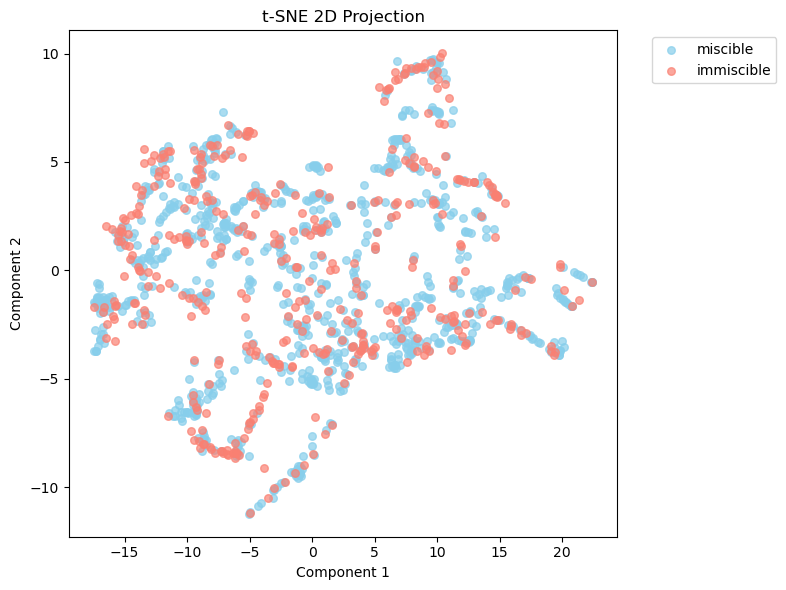

In [32]:
X = df_total.iloc[:, 0:-1].values
y = df_total['miscibility'].values

# 2. PCA
reducer = TSNE(n_components=3, random_state=42)  
X_reduced = reducer.fit_transform(X)

# explained_variance = pca.explained_variance_ratio_

# 3. Color mapping for two miscibility types
miscibility_types = df_total['miscibility'].unique()
if len(miscibility_types) != 2:
    print(f"Warning: Found {len(miscibility_types)} unique miscibility types. Ensure there are exactly two for the color mapping.")

colors = ['skyblue', 'salmon']  # Define your two colors
color_dict = dict(zip(miscibility_types, colors))
legends = ['miscible', 'immiscible']
# 4. 2D Scatter Plot
plt.figure(figsize=(8, 6))
for i, surfactant in enumerate(miscibility_types):
    idx = (y == surfactant)
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1],
                color=color_dict[surfactant],
                label=legends[i], alpha=0.7, s=30)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE 2D Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. 3D Interactive Scatter Plot
traces = []
for surfactant in miscibility_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_reduced[idx, 0],
        y=X_reduced[idx, 1],
        z=X_reduced[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color_dict[surfactant],
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=str(surfactant)
    )
    traces.append(trace)

layout = go.Layout(
    title='t-SNE 3D Projection',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    legend=dict(title='Miscible or not (1 for miscible, 0 for immisible')
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)


### Amphiphiles data

In [12]:
# joblib.dump((x_latent_am, y_am), "amphiphiles_mixture_latent_VICGAE.joblib")
x_latent_am, y_am = joblib.load("amphiphiles_mixture_latent_VICGAE.joblib")

In [13]:
x_latent_am.shape

(336, 32)

In [14]:
df_total = pd.concat([pd.DataFrame(x_latent_am), pd.DataFrame(y_am, columns=['vesicles_formation'])],axis=1)
df_total.shape

(336, 33)

In [15]:
df_total.to_csv('df_total_amphiphiles_VICGAE_20250707.csv', index=False)

In [36]:
df_total.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,vesicles_formation
0,0.454552,-0.580540,0.691084,0.663652,-0.674400,0.590582,0.045821,0.204892,0.626809,-0.733649,...,0.621271,-0.518695,-0.633017,-0.600037,0.741957,0.620581,-0.596593,0.765812,0.000270,1
1,0.305071,-0.399811,0.502621,0.478180,-0.469659,0.416777,0.039440,0.139480,0.455284,-0.508367,...,0.431812,-0.361923,-0.425970,-0.433554,0.518499,0.423500,-0.414739,0.540593,0.002693,1
2,0.440462,-0.586795,0.683199,0.646729,-0.658822,0.581412,0.050957,0.210741,0.612306,-0.718068,...,0.611100,-0.503275,-0.621513,-0.591864,0.727512,0.612978,-0.578327,0.756198,0.011050,1
3,0.394442,-0.433037,0.600135,0.569720,-0.529105,0.498757,0.039715,0.124136,0.593655,-0.574434,...,0.515938,-0.412057,-0.445872,-0.522371,0.577599,0.466796,-0.504535,0.612271,0.009988,1
4,0.489363,-0.556053,0.674175,0.625960,-0.635965,0.577974,0.047797,0.192544,0.628469,-0.696038,...,0.610048,-0.478585,-0.584724,-0.588720,0.689727,0.589660,-0.594484,0.724836,0.006592,1


In [37]:
data_ = df_total.copy()
train_df, test_df = train_test_split(
        data_,
        test_size=0.2,  
        random_state=42  # for reproducibility
    )

train_x = train_df.iloc[:,0:-1]
train_y = train_df['vesicles_formation']

test_x = test_df.iloc[:,0:-1]
test_y = test_df['vesicles_formation']

In [38]:
clf, y_pred, roc_auc, fpr, tpr, threshold = run_classifier_update(train_x, train_y, test_x, test_y, classifier_alter=True)

ROC-AUC Score: 0.8321


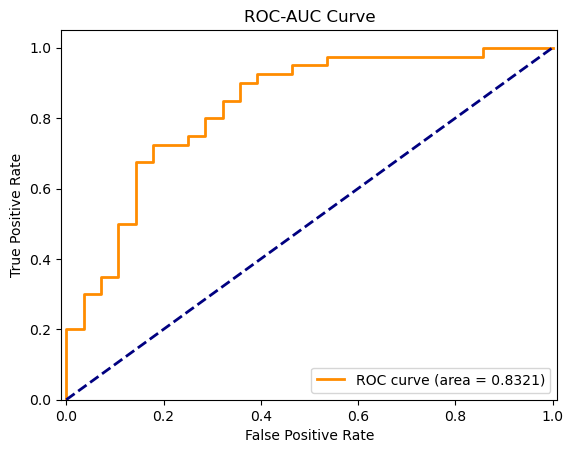

In [39]:
fig, ax = plt.subplots()
ax.set_title("ROC-AUC Curve")
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.set_title(f'ROC ({feature}_removed)')
ax.legend(loc='lower right')

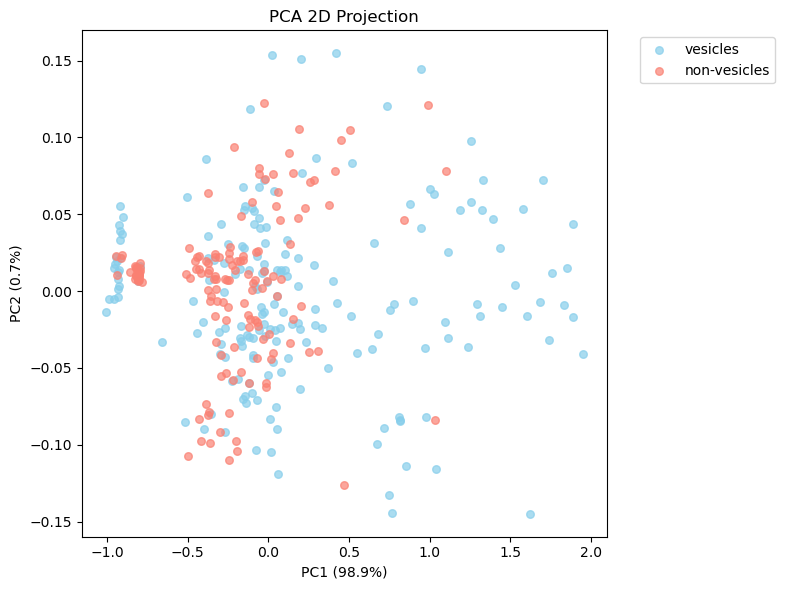

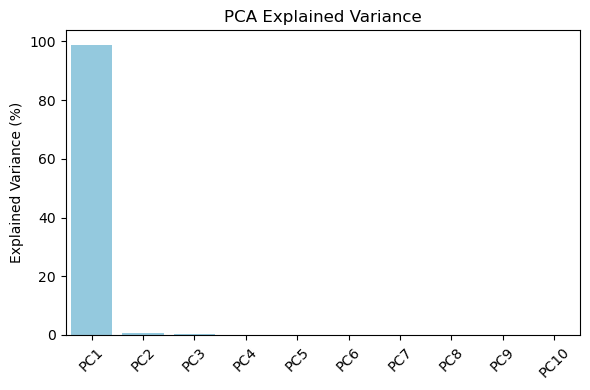

In [40]:
X = df_total.iloc[:, 0:-1].values
y = df_total['vesicles_formation'].values

# 2. PCA
pca = PCA(n_components=10)  # Keep more components initially
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_

# 3. Color mapping for two miscibility types
miscibility_types = df_total['vesicles_formation'].unique()
if len(miscibility_types) != 2:
    print(f"Warning: Found {len(miscibility_types)} unique miscibility types. Ensure there are exactly two for the color mapping.")

colors = ['skyblue', 'salmon']  # Define your two colors
color_dict = dict(zip(miscibility_types, colors))
legends = ['vesicles', 'non-vesicles']
# 4. 2D Scatter Plot
plt.figure(figsize=(8, 6))
for i, surfactant in enumerate(miscibility_types):
    idx = (y == surfactant)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=color_dict[surfactant],
                label=legends[i], alpha=0.7, s=30)

plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
plt.title('PCA 2D Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. 3D Interactive Scatter Plot
traces = []
for surfactant in miscibility_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_pca[idx, 0],
        y=X_pca[idx, 1],
        z=X_pca[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color_dict[surfactant],
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=str(surfactant)
    )
    traces.append(trace)

layout = go.Layout(
    title='PCA 3D Projection',
    scene=dict(
        xaxis_title=f'PC1 ({explained_variance[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({explained_variance[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({explained_variance[2]*100:.1f}%)'
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    legend=dict(title='Vesicles or not (1 for vesicles, 0 for non-vesicles')
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)

# 6. Explained Variance Plot (remains the same as it shows overall variance)
plt.figure(figsize=(6, 4))
sns.barplot(x=[f'PC{i+1}' for i in range(10)], y=explained_variance*100, color='skyblue')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

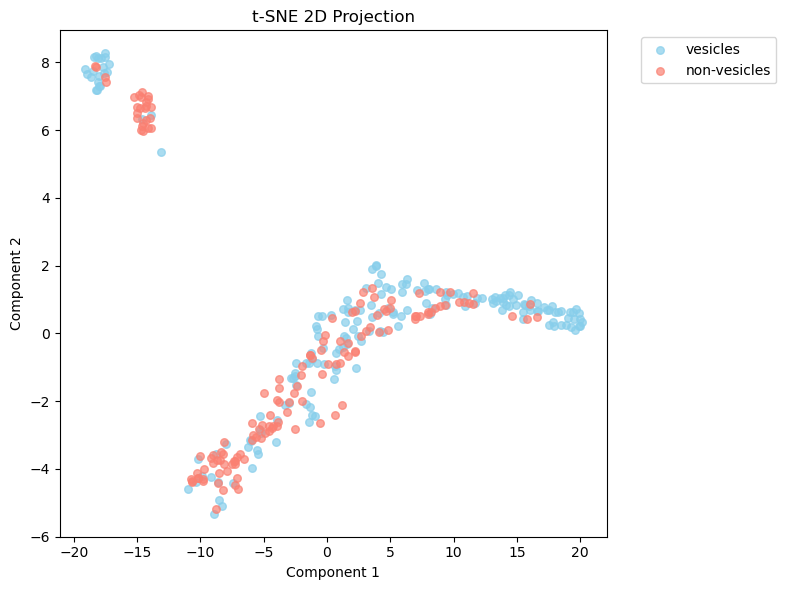

In [41]:
X = df_total.iloc[:, 0:-1].values
y = df_total['vesicles_formation'].values

# 2. PCA
reducer = TSNE(n_components=3, random_state=42)  
X_reduced = reducer.fit_transform(X)

# explained_variance = pca.explained_variance_ratio_

# 3. Color mapping for two miscibility types
miscibility_types = df_total['vesicles_formation'].unique()
if len(miscibility_types) != 2:
    print(f"Warning: Found {len(miscibility_types)} unique miscibility types. Ensure there are exactly two for the color mapping.")

colors = ['skyblue', 'salmon']  # Define your two colors
color_dict = dict(zip(miscibility_types, colors))
legends = ['vesicles', 'non-vesicles']
# 4. 2D Scatter Plot
plt.figure(figsize=(8, 6))
for i, surfactant in enumerate(miscibility_types):
    idx = (y == surfactant)
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1],
                color=color_dict[surfactant],
                label=legends[i], alpha=0.7, s=30)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE 2D Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. 3D Interactive Scatter Plot
traces = []
for surfactant in miscibility_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_reduced[idx, 0],
        y=X_reduced[idx, 1],
        z=X_reduced[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color_dict[surfactant],
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=str(surfactant)
    )
    traces.append(trace)

layout = go.Layout(
    title='t-SNE 3D Projection',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    legend=dict(title='Vesicles or not (1 for vesicles, 0 for non-vesicles')
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)
